<a href="https://colab.research.google.com/github/andreYoo/Time-series-analysis-anomaly-detection/blob/main/Day1_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
# 분석에 필요한 라이브러리 호출 

import pandas as pd # 판다스 호출 
import numpy as np  # 넘파이 호출 
import statsmodels.api as sm # statsmodels 호출 
import seaborn as sns # 그래프를 그리기위한 Seaborn 호출 
from statsmodels.tsa.seasonal import seasonal_decompose # 데이터 필터 라이러리 호출 
import matplotlib.pyplot as plt

In [83]:
# 구글 드라이브 마운트 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
# 데이터 호출 함수  
def readData (path):
  df = pd.read_excel(path)
  return df 

In [85]:
# 분석에 사용할 시간별 대한민국 전력 수요 데이터 호출 
path = './drive/MyDrive/study/일간최대전력실적.xlsx'
need_df = readData(path)
study_df = pd.DataFrame()
study_df['MaxPower(MW)'] = need_df['최대전력(MW)']
study_df['time'] = need_df['최대전력기준일시']
study_df

,MaxPower(MW),time
0,70090,2022/01/16(19:00)
1,71585,2022/01/15(09:00)
2,87278,2022/01/14(09:00)
3,89115,2022/01/13(17:00)
4,88305,2022/01/12(10:00)
...,...,...
1107,69496,2019/01/05(11:00)
1108,84746,2019/01/04(10:00)
1109,84196,2019/01/03(10:00)
1110,82437,2019/01/02(10:00)


In [86]:
# 시간 데이터 타입 확인 
study_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112 entries, 0 to 1111
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MaxPower(MW)  1112 non-null   int64 
 1   time          1112 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.5+ KB


In [87]:
# time을 시계열 데이터로 변경 
study_df['time'] = study_df['time'].str[0:10]
study_df['time'] = pd.to_datetime(study_df['time'])
study_df.set_index('time',drop=True,inplace=True)
study_df = study_df.sort_index()
study_df

,MaxPower(MW)
time,
2019-01-01,65493
2019-01-02,82437
2019-01-03,84196
2019-01-04,84746
2019-01-05,69496
...,...
2022-01-12,88305
2022-01-13,89115
2022-01-14,87278


In [88]:
study_df[study_df.index.duplicated()]

,MaxPower(MW)
time,


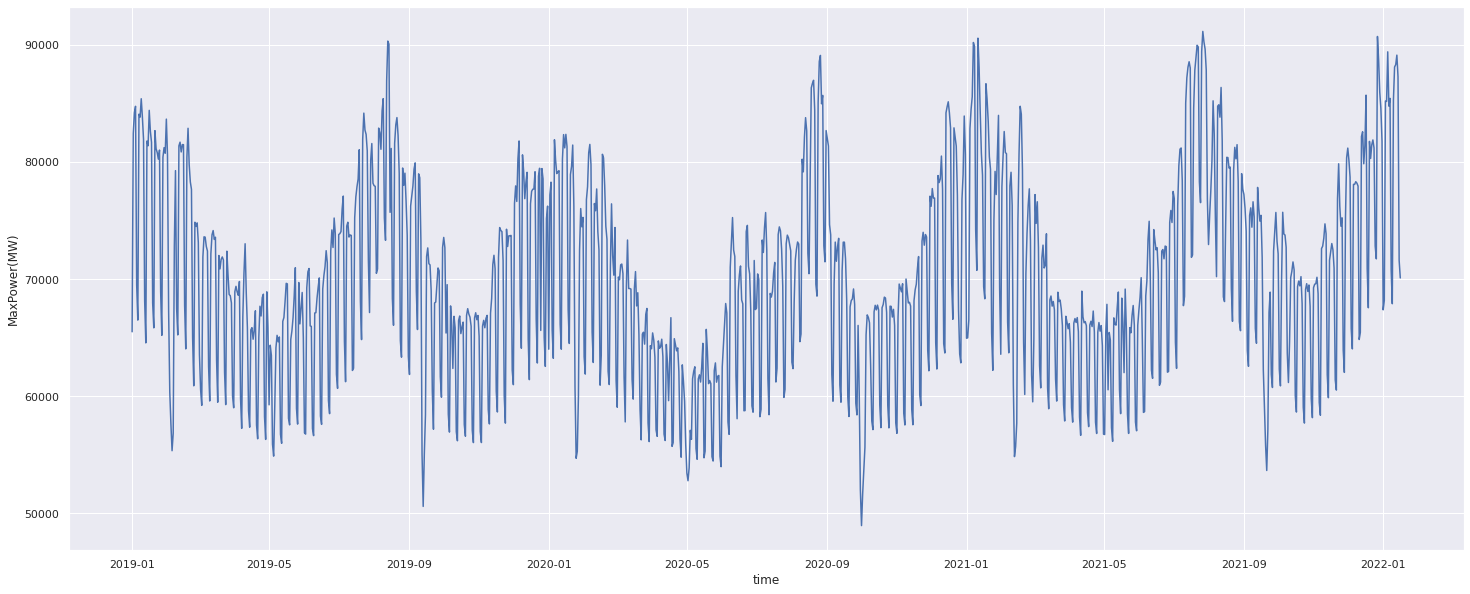

In [89]:
# 최대 전력 수요 가시화 
sns.set(rc={'figure.figsize':(25,10)})
sns.lineplot(x=study_df.index , y=study_df['MaxPower(MW)'])

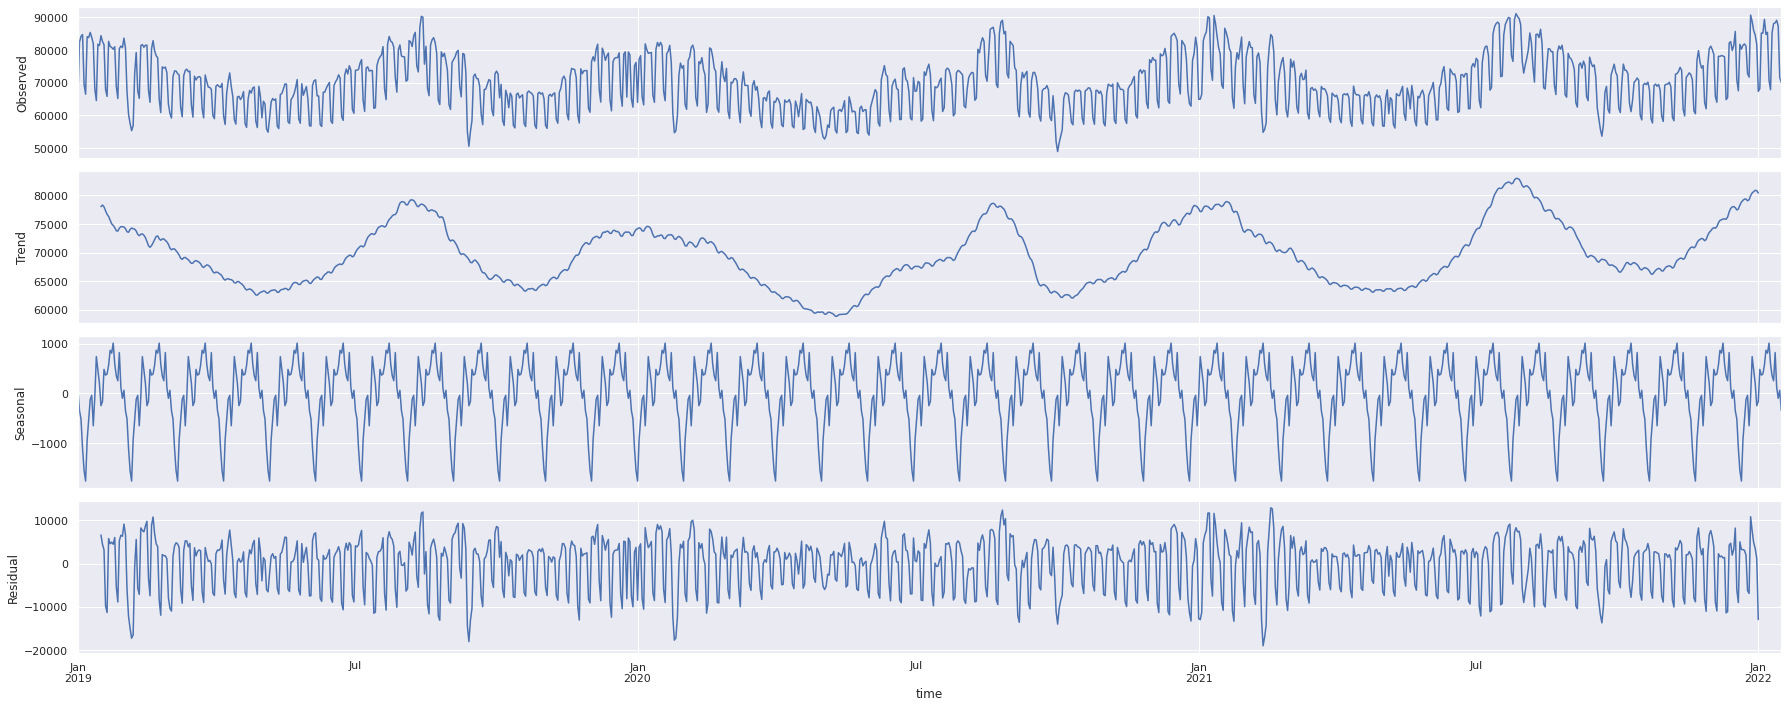

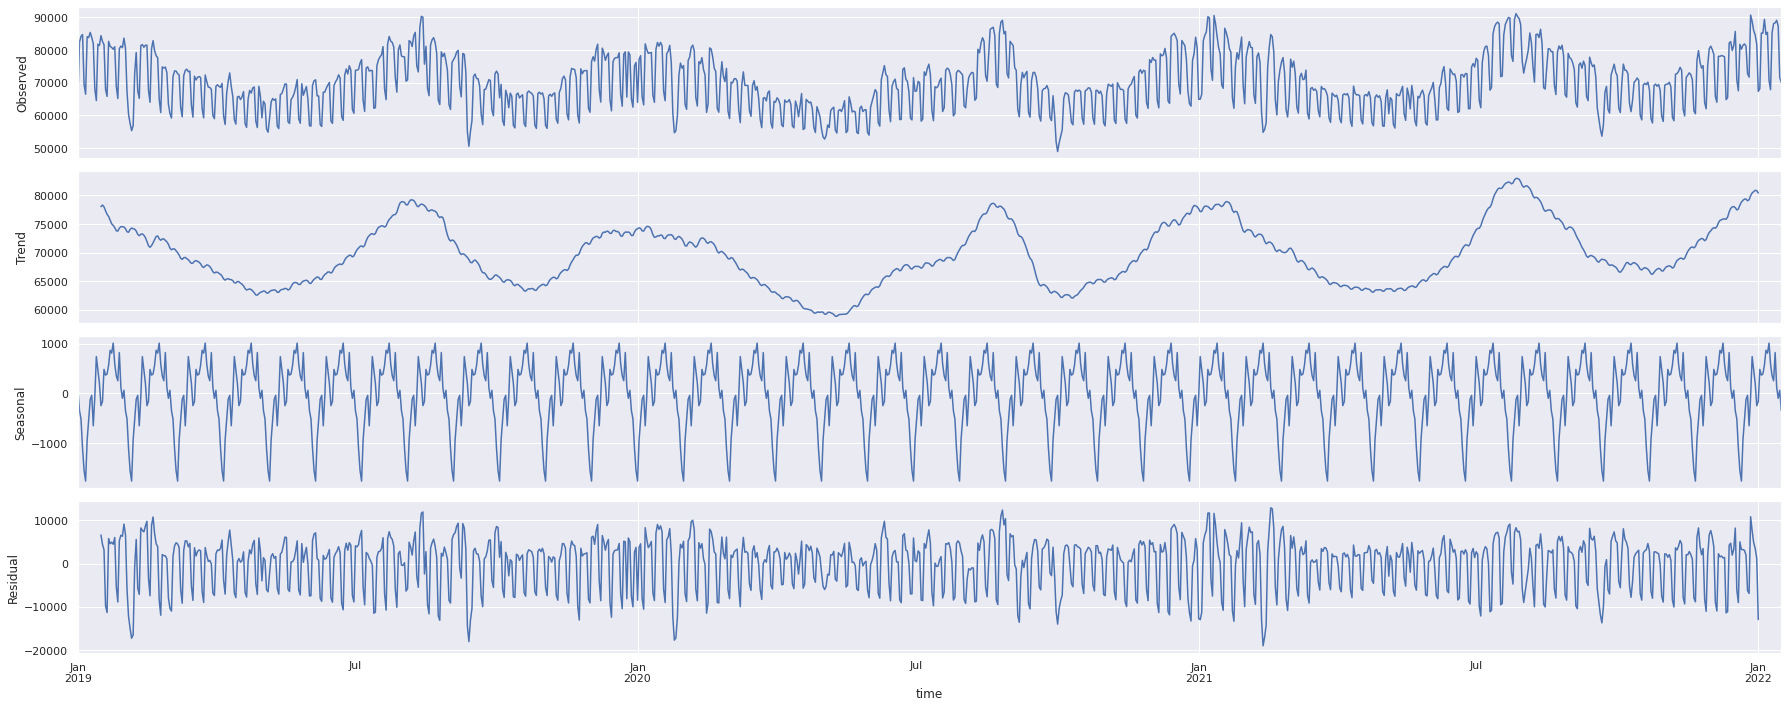

In [90]:
# Seasnonl Decompose 모델로 시계열 육안 확인 
result = seasonal_decompose(study_df, model='Mulitiolicative', freq= 30) # 대략 1달치 기준으로 데이터 분해 실시  
result.plot()

# 월간 시계열성이 강하다. 

In [91]:
# 데이터 정상 상태 수치 확인 
from statsmodels.tsa.stattools import adfuller #ADF Test를 위한 함수 호출 

st_result = adfuller(study_df['MaxPower(MW)'])
print(st_result)

study_df['1st diff'] = study_df['MaxPower(MW)']- study_df['MaxPower(MW)'].shift(1)

# Test 결과 이미 P-Velue 가 0.05 이하 임으로 시계열 데이터가 정상 상태로 판다.
# 만약 0.05 이상 이라면 차분을 통해 시계열 안정화 실시 

(-3.311086493867086, 0.014390122875637573, 21, 1090, {'1%': -3.4363635475753824, '5%': -2.864195245967465, '10%': -2.5681837404258903}, 20542.010885426014)


1.6725546571976814e-13


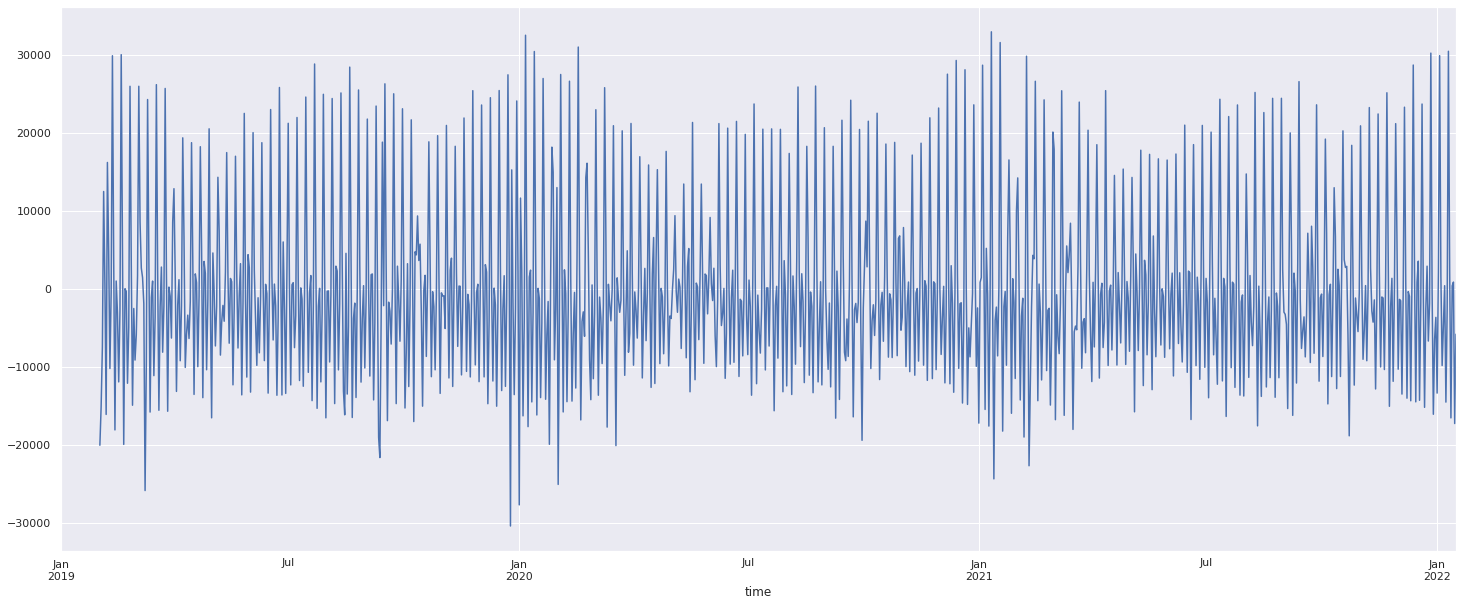

In [92]:
# diff 값으로 계절성 값 계산 

study_df['seasonal diff'] = study_df['1st diff'] - study_df['1st diff'].shift(30)
st_result = adfuller(study_df['seasonal diff'].dropna()) # 차분에 의해 발생한 Na 값을 제거 하고 진행 
print(st_result[1])
study_df['seasonal diff'].plot()

# 결론적으로 ARIMA의 차분 값은 
#d = 0, D = 1 사용 

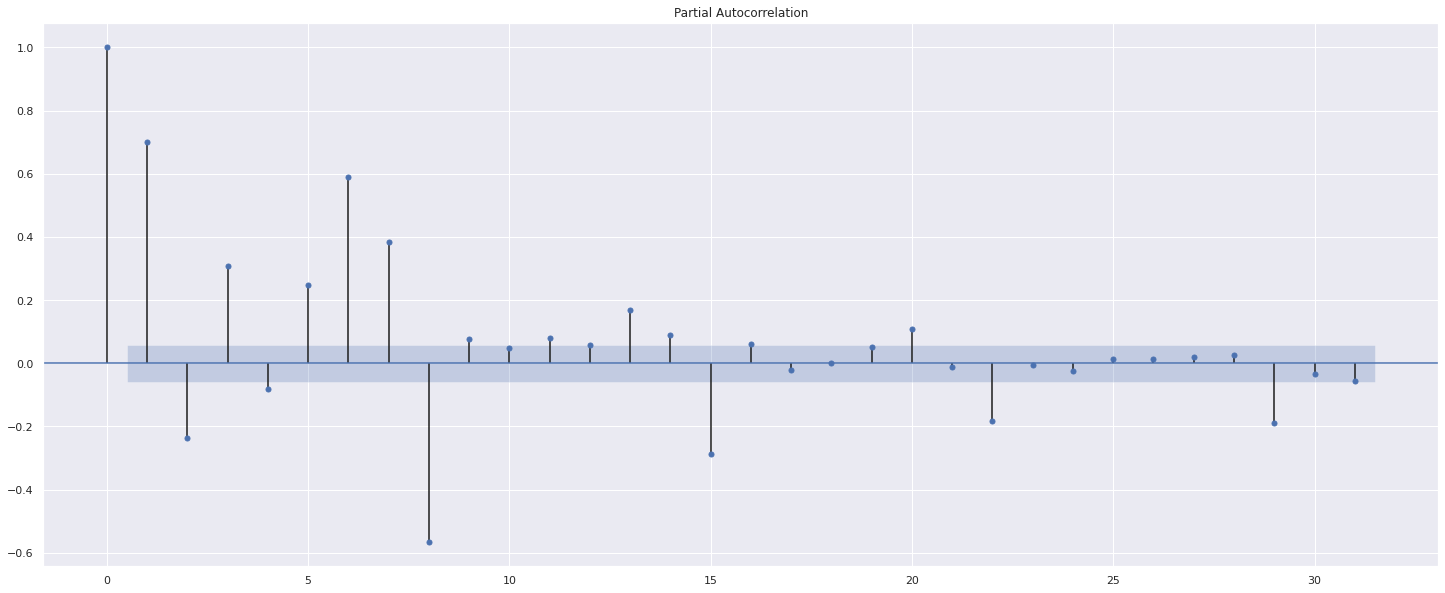

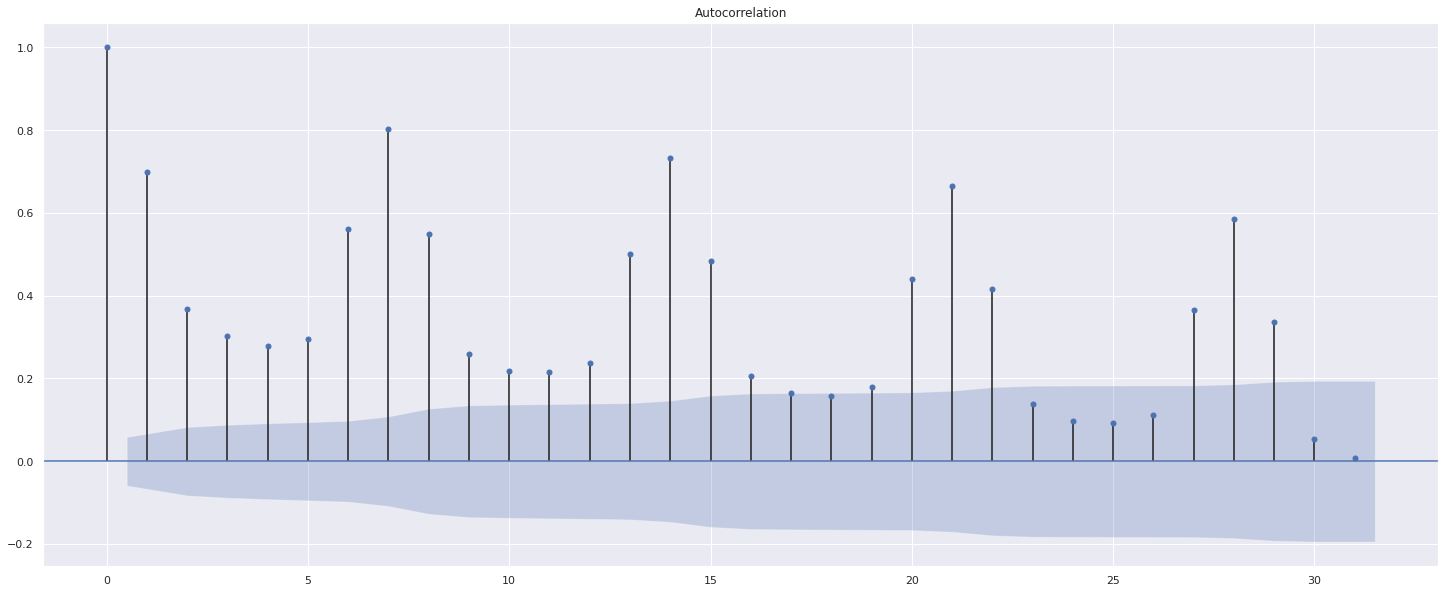

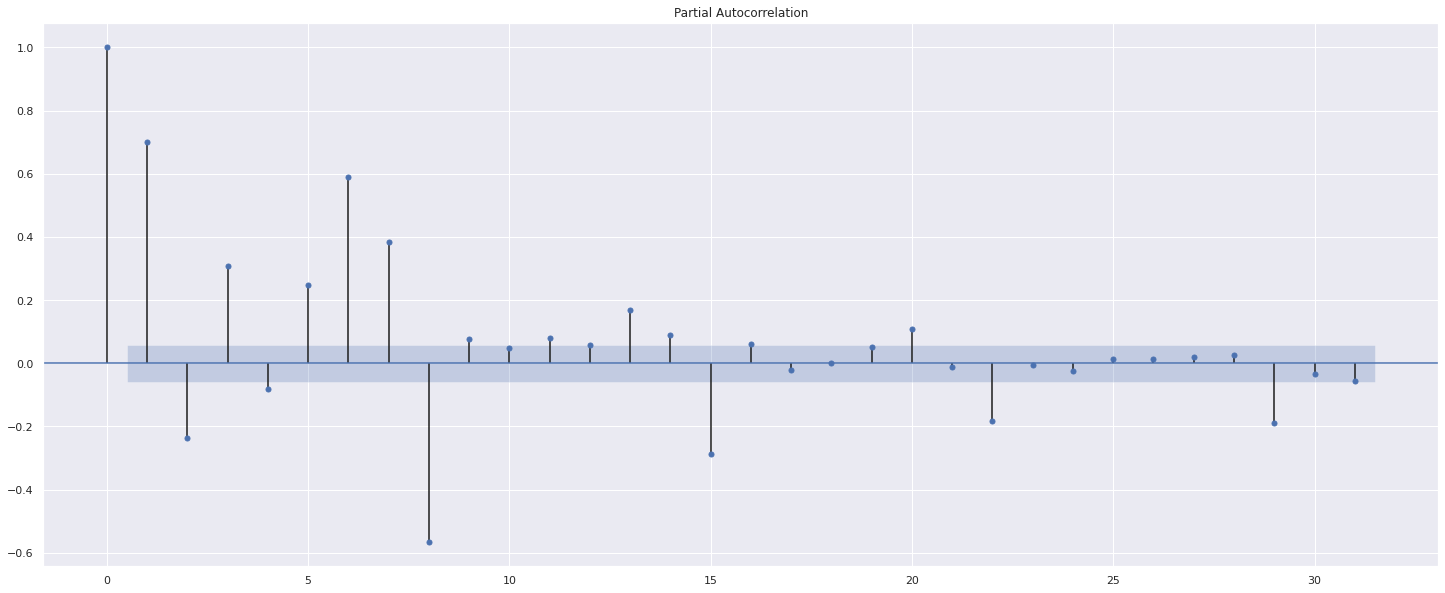

In [93]:
# ACF 그려 보기 / PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # acf 와 pacf 시각화를 위한 라이브러리 호출 

plot_acf(study_df['MaxPower(MW)'])
plot_pacf(study_df['MaxPower(MW)'])

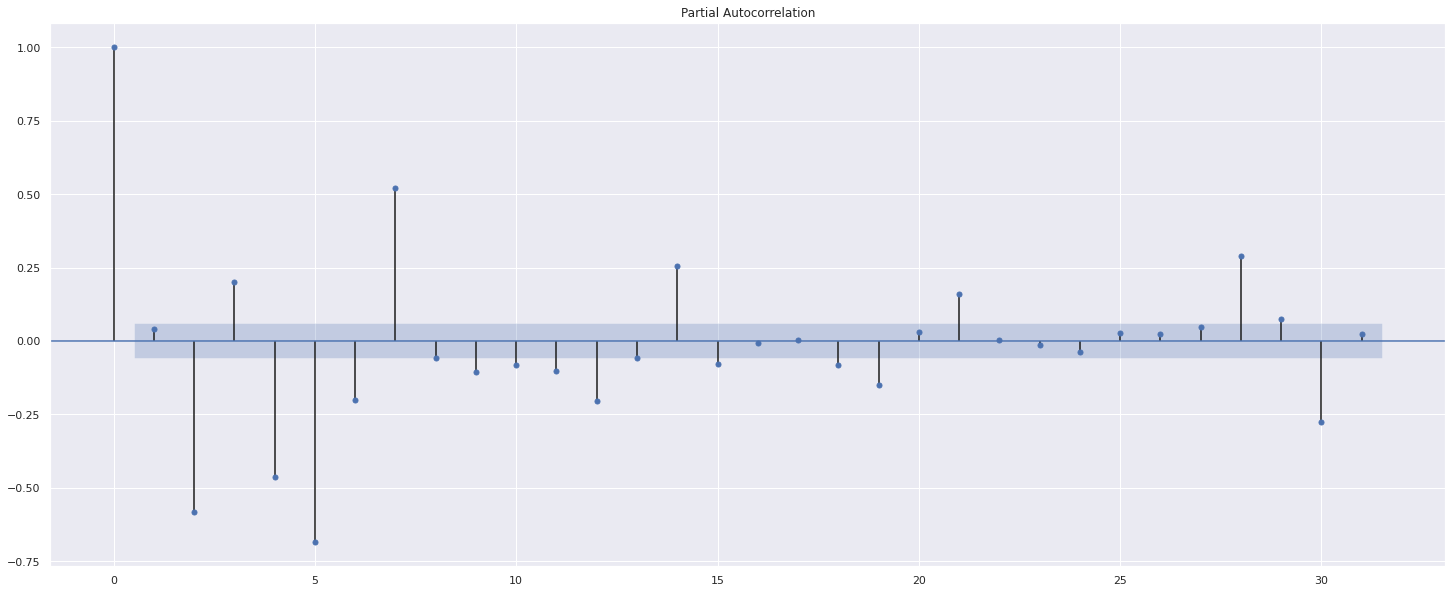

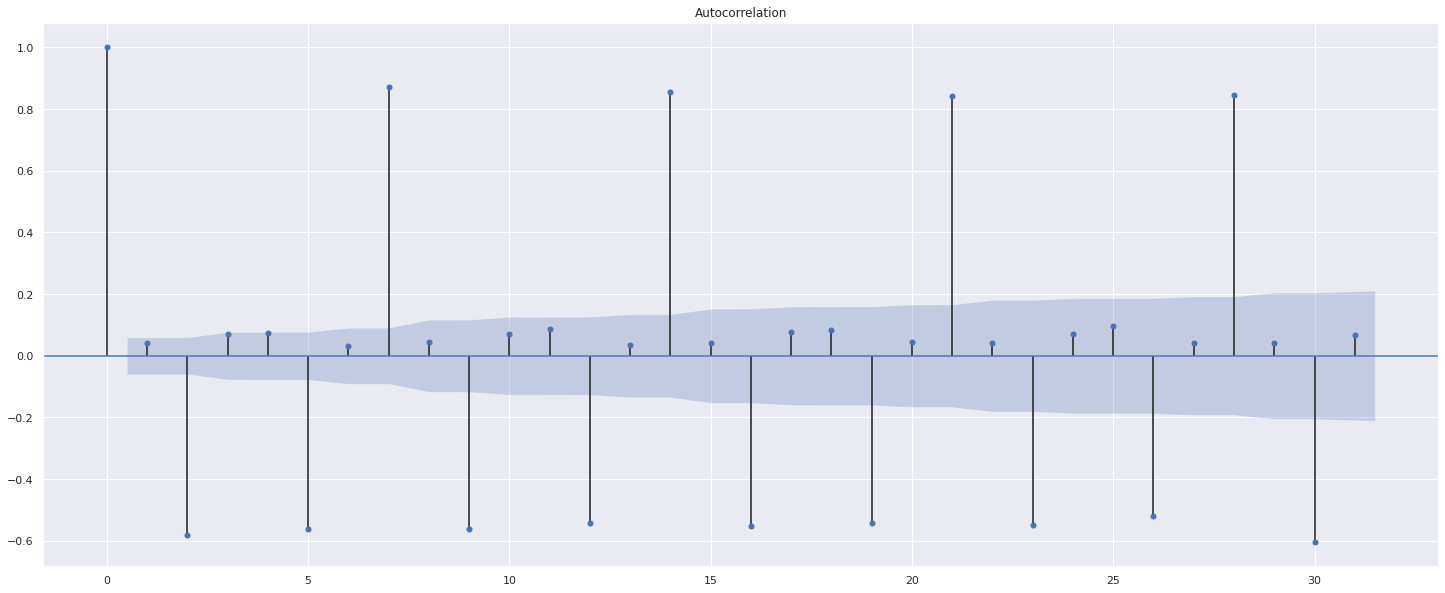

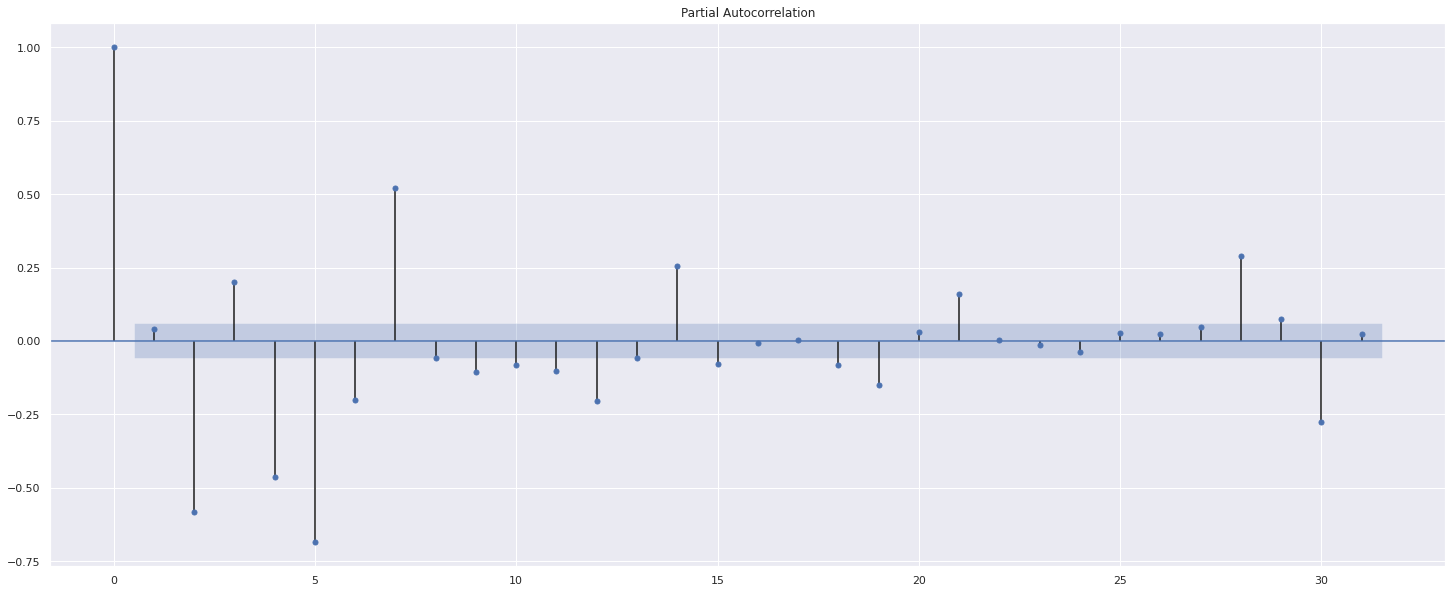

In [94]:
# ACF 그려 보기 / PACF (계절성)

plot_acf(study_df['seasonal diff'].dropna())
plot_pacf(study_df['seasonal diff'].dropna())

In [95]:
# Arima 예측 
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(study_df['MaxPower(MW)'], order=(0,2,1))
model_fit = model.fit(trend='nc',full_output=True, disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:        D2.MaxPower(MW)   No. Observations:                 1110
Model:                 ARIMA(0, 2, 1)   Log Likelihood              -11348.181
Method:                       css-mle   S.D. of innovations           6644.256
Date:                Mon, 17 Jan 2022   AIC                          22700.361
Time:                        04:24:09   BIC                          22710.385
Sample:                    01-03-2019   HQIC                         22704.152
                         - 01-16-2022                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
ma.L1.D2.MaxPower(MW)    -1.0000      0.002   -451.334      0.000      -1.004      -0.996
                                    Roots                                    
                  Re

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


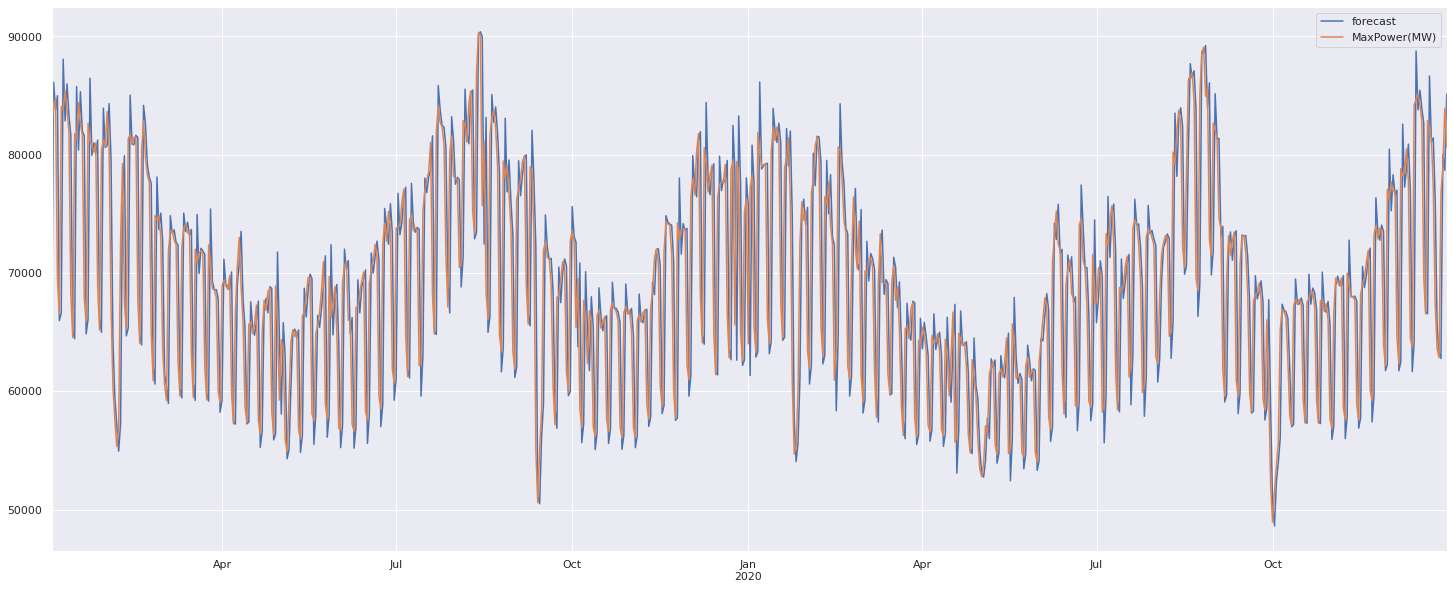

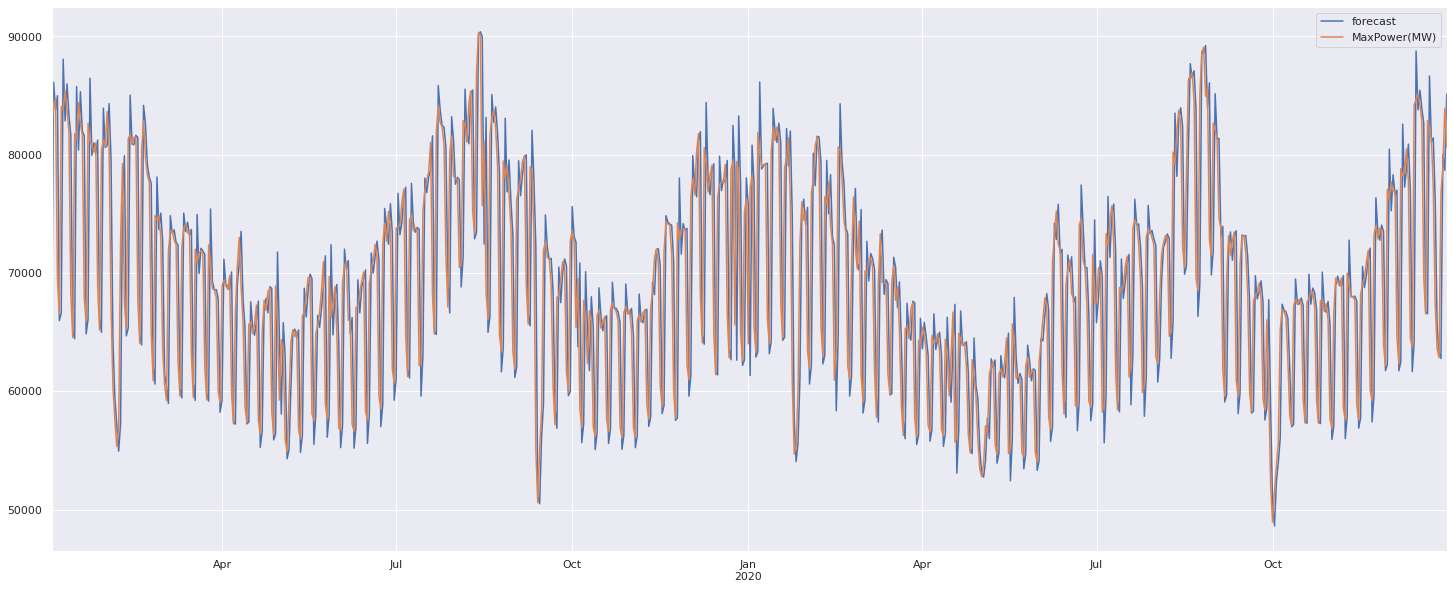

In [101]:
# 시각화 하기 
model_fit.plot_predict()

In [104]:
# 미래 예측 및 종료 
# 19~20년 까지 데이터를 활용하여 ARIMA로 예측하고 21년도 데이터와 오차 계산해 보자 

df_1920 = study_df['2019-01':'2020-12']

model = ARIMA(df_1920['MaxPower(MW)'], order=(0,1,1))
model_fit = model.fit(trend='c',full_output=True, disp=1)
fore = model_fit.forecast(steps=62,alpha=0.05)
fore_df = pd.DataFrame()
result_df = study_df['2021-07':'2021-08']
fore_df['Real'] = result_df['MaxPower(MW)']
fore_df.reset_index(drop=False)
fore
fore_df['ARIMA'] = fore[0]
temp_df = study_df['2020-07-01':'2020-07-27'].reset_index()
fore_df.reset_index(inplace=True)
fore_df['20year'] = temp_df['MaxPower(MW)']*1.05

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [105]:
fore_df

,time,Real,ARIMA,20year
0,2021-07-01,77476,79626.348223,70885.50
1,2021-07-02,76865,79647.086603,73956.75
2,2021-07-03,64612,79667.824983,73453.80
3,2021-07-04,62368,79688.563363,61153.05
4,2021-07-05,76256,79709.301743,61822.95
...,...,...,...,...
57,2021-08-27,78339,80808.435879,NaN
58,2021-08-28,66357,80829.174259,NaN
59,2021-08-29,65588,80849.912639,NaN
60,2021-08-30,78996,80870.651019,NaN


In [106]:
mod = sm.tsa.statespace.SARIMAX(df_1920['MaxPower(MW)'].shift(1), order=(2,1,2),seasonal_order=(0,1,0,30)).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [107]:
print(mod.summary())

                                 Statespace Model Results                                 
Dep. Variable:                       MaxPower(MW)   No. Observations:                  731
Model:             SARIMAX(2, 1, 2)x(0, 1, 0, 30)   Log Likelihood               -7326.933
Date:                            Mon, 17 Jan 2022   AIC                          14663.866
Time:                                    04:30:09   BIC                          14686.621
Sample:                                01-01-2019   HQIC                         14672.662
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1191      0.055      2.146      0.032       0.010       0.228
ar.L2         -0.2523      0.050   

In [108]:
df = pd.DataFrame()
df['ARIMA'] = mod.predict(start = 365*2+1, end= 365*2+30, dynamic= True)

In [109]:
real = study_df['2021-01':'2021-01']
df['Real'] = real['MaxPower(MW)']

In [110]:
df['erro'] = (df['ARIMA'] - df['Real']) / df['ARIMA'] * 100

In [111]:
erro = abs(df['erro']).mean()

In [112]:
erro

14.424361744827946